### Business and data understanding

#### Business question: Apple is eager to assess employee satisfaction and identify areas for improvement to enhance the overall workplace environment. As a data analyst, my role is to assist the company in understanding employee feedback and sentiments. By analyzing what employees are saying about Apple, we can pinpoint specific areas that need attention and foster a more positive and productive work environment. 

#### For the web crawling I will use Career bliss website.

#### Significance of the problem: Apple wnats to keep thier employees for a long term and attrack new talent. 

#### Business value: This can help Apple to improvise their strategy for employee engagement & employee satisfaction.

#### Data Dictionary: Ratings by Category out of 5 from Apple Employee in United States
* Company Culture
* People You Work With
* People You Work For
* Growth Opportunities
* Rewards You Receive
* Support You Get
* Way You Work
* Work Setting  

In [1]:
# import packeges
import pandas as pd
import re
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from itertools import combinations


pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from os import path
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

# gensim for topic modeling
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim.models.ldamodel import LdaModel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Read csv file
df = pd.read_csv("apple_reviewDF.csv")
df.head()

,job_title,employee_review,state,review_url,person_you_work_for,people_you_work_with,work_setting,support,rewards,growth,culture
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Technical Specialist,"""It was a great company to work for, they definitely helped develop me as a person.""","Dallas, TX",https://www.careerbliss.com/apple/reviews/technical-specialist/#2027278,5.0,5.0,5.0,5.0,3.0,5.0,5.0
2,Apple Employee,"""Excellent place of work and a great opportunity to grow and learn.""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/anonymous-employee/#2025917,5.0,4.0,4.0,5.0,3.0,5.0,3.0
3,Specialist,NaN,"Mission Viejo, CA",https://www.careerbliss.com/apple/reviews/specialist/#2024880,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,Product Service Engineering Technician,"""I was welcomed by the entire team since the beginning. The first couple of months were meant for me to adapt to the team, the processes, the goals, and the mentality. Later on I started receiving my own projects with open freedom to develop them while receiving guidance by my supervisor along the way. I would definitely recommend a job with Apple.""","Cupertino, CA",https://www.careerbliss.com/apple/reviews/product-service-engineering-technician/#2023701,5.0,4.0,5.0,5.0,4.0,4.0,5.0


In [3]:
# removing na value
apple_df = df.dropna()
apple_df.dtypes

job_title                object
employee_review          object
state                    object
review_url               object
person_you_work_for     float64
people_you_work_with    float64
work_setting            float64
support                 float64
rewards                 float64
growth                  float64
culture                 float64
dtype: object

In [4]:
# removing decimal
num_columns = ['person_you_work_for', 'people_you_work_with', 'work_setting', 'support', 'rewards', 'growth', 'culture']
apple_df[num_columns] = apple_df[num_columns].astype(int)
apple_df.head(2)

,job_title,employee_review,state,review_url,person_you_work_for,people_you_work_with,work_setting,support,rewards,growth,culture
1,Technical Specialist,"""It was a great company to work for, they definitely helped develop me as a person.""","Dallas, TX",https://www.careerbliss.com/apple/reviews/technical-specialist/#2027278,5,5,5,5,3,5,5
2,Apple Employee,"""Excellent place of work and a great opportunity to grow and learn.""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/anonymous-employee/#2025917,5,4,4,5,3,5,3


In [5]:
# data types
apple_df.dtypes

job_title               object
employee_review         object
state                   object
review_url              object
person_you_work_for      int32
people_you_work_with     int32
work_setting             int32
support                  int32
rewards                  int32
growth                   int32
culture                  int32
dtype: object

In [6]:
# Creating function 

def clean_pipeline(employee_review):
    
    # lower all the cases in 'Review_text'
    employee_review= str(employee_review).lower()
    
    # tokenizing sentences into words
    token_list = word_tokenize(employee_review)

    # removing special characters, keeping words and numbers
    employee_review= re.sub("[^a-zA-Z]", " ", employee_review)
    
    # Load the default NLTK stopwords set for English
    stop_words = set(stopwords.words('english'))
        
    # Define your own set of additional stopwords to add
    additional_stopwords = {'worked', 'working', 'work', 'apple'}
    
    # Combine the default set with your additional stopwords
    stop_words = stop_words.union(additional_stopwords)
    

    # removing stopwords
    filtered_tokens = [word for word in token_list if word not in stop_words]    

    return filtered_tokens

In [7]:
# Apply clean_pipeline function and create new column named cleaned_review_text
apple_df['Cleaned_Review_Text'] = apple_df['employee_review'].apply(clean_pipeline)
apple_df['Cleaned_Review_Text'] = apple_df['Cleaned_Review_Text'].apply(lambda x:" ".join(x))
apple_df.head()

,job_title,employee_review,state,review_url,person_you_work_for,people_you_work_with,work_setting,support,rewards,growth,culture,Cleaned_Review_Text
1,Technical Specialist,"""It was a great company to work for, they definitely helped develop me as a person.""","Dallas, TX",https://www.careerbliss.com/apple/reviews/technical-specialist/#2027278,5,5,5,5,3,5,5,"`` great company , definitely helped develop person . ''"
2,Apple Employee,"""Excellent place of work and a great opportunity to grow and learn.""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/anonymous-employee/#2025917,5,4,4,5,3,5,3,`` excellent place great opportunity grow learn . ''
4,Product Service Engineering Technician,"""I was welcomed by the entire team since the beginning. The first couple of months were meant for me to adapt to the team, the processes, the goals, and the mentality. Later on I started receiving my own projects with open freedom to develop them while receiving guidance by my supervisor along the way. I would definitely recommend a job with Apple.""","Cupertino, CA",https://www.careerbliss.com/apple/reviews/product-service-engineering-technician/#2023701,5,4,5,5,4,4,5,"`` welcomed entire team since beginning . first couple months meant adapt team , processes , goals , mentality . later started receiving projects open freedom develop receiving guidance supervisor along way . would definitely recommend job . ''"
5,Senior Front End Developer,"""It is a great company to work for""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/senior-front-end-developer/#2021824,4,5,4,5,4,4,5,`` great company ''
6,Technical Product Manager,"""I have worked in Apple and I have enjoyed what I have learnt in this organization. It has taught me to make products which appeal to the consumer and simplify the process. Excellent opportunity""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/technical-product-manager/#2007097,5,5,5,5,4,5,5,`` enjoyed learnt organization . taught make products appeal consumer simplify process . excellent opportunity ''


### 1. Part I: Descriptive Analytics - Word cloud / Word Frequency - Business intelligence & Data visualization 

In [8]:
# Avg rating
avg_rating = apple_df[['person_you_work_for', 'people_you_work_with', 'work_setting', 'support', 'rewards', 'growth', 'culture']].mean()
print("Average ratings for Apple Company")
print(avg_rating)

Average ratings for Apple Company
person_you_work_for     4.547945
people_you_work_with    4.630137
work_setting            4.452055
support                 4.452055
rewards                 4.164384
growth                  4.027397
culture                 4.356164
dtype: float64


In [9]:
# Initialize CountVectorizer for bigrams
cv = CountVectorizer(ngram_range=(2, 2))

# Fit and transform the cleaned documents
vocab = cv.fit_transform(apple_df['Cleaned_Review_Text'])

# Create a DataFrame for bigram frequencies without modifying the original DataFrame
bigram_df = pd.DataFrame(vocab.toarray(), columns=cv.get_feature_names_out())

# Sum the counts of each bigram across all documents to get the total frequency of each bigram
bigram_frequencies = bigram_df.sum(axis=0)

# Sort and display the top 20 bigrams
print(bigram_frequencies.sort_values(ascending=False).head(20))


great company       8
business objects    5
full time           5
great experience    4
customer service    4
one best            4
years experience    3
years time          3
xi r2               3
amazing company     3
two years           3
since 2018          3
learned lot         3
service skills      2
grow learn          2
strong company      2
sql server          2
almost year         2
part time           2
excellent place     2
dtype: int64


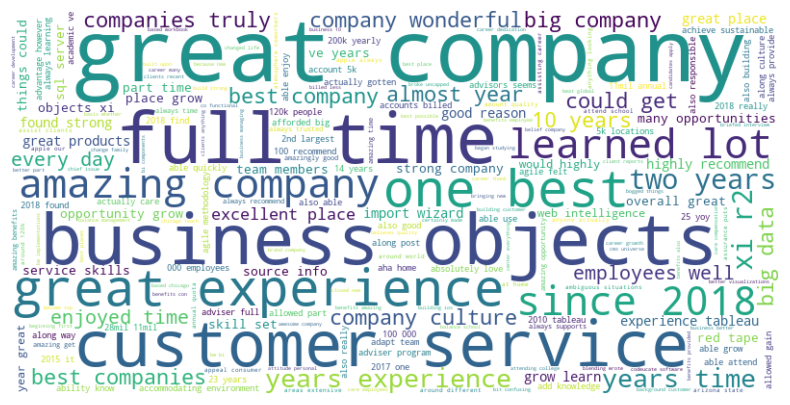

In [10]:
# generate bigram word cloud

wordcloud = WordCloud(width=800, height=400, 
                      background_color='white').generate_from_frequencies(bigram_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Part II: Content Analytics - Text classification OR Topic modeling - Sentiment analysis - Business intelligence & Data visualization

### Sentiment Analysis

#### Bing-Liu

In [11]:
#Bing-Liu lexicon (positive word list & negative word list)
positive_words = open("9_Sentiment_Analysis/data/positive-words.txt", "r", encoding = "ISO-8859-1").read().splitlines()
negative_words = open("9_Sentiment_Analysis/data/negative-words.txt", "r", encoding = "ISO-8859-1").read().splitlines()

print(len(positive_words), len(negative_words))

2006 4783


In [12]:
sentiment_df = []
for sentence in apple_df['Cleaned_Review_Text']:
    
    positive = 0
    negative = 0
    
    for word in sentence:
        if word in positive_words:
            positive += 1
        elif word in negative_words:
            negative += 1
    sentiment_df.append([sentence,positive, negative, positive-negative, "Positive" if positive-negative > 0 else "Neutral" if positive-negative == 0 else "Negative"])
len(sentiment_df)

73

In [13]:
# create a dataframe and name 
sentiment_bing= pd.DataFrame(sentiment_df)
sentiment_bing.columns = ['review', 'positive', 'negative', 'compoundscore', 'sentiment']
sentiment_bing.head(5)

,review,positive,negative,compoundscore,sentiment
0,"`` great company , definitely helped develop person . ''",0,0,0,Neutral
1,`` excellent place great opportunity grow learn . '',0,0,0,Neutral
2,"`` welcomed entire team since beginning . first couple months meant adapt team , processes , goals , mentality . later started receiving projects open freedom develop receiving guidance supervisor along way . would definitely recommend job . ''",0,0,0,Neutral
3,`` great company '',0,0,0,Neutral
4,`` enjoyed learnt organization . taught make products appeal consumer simplify process . excellent opportunity '',0,0,0,Neutral


In [14]:
sentiment_bing.describe()

,positive,negative,compoundscore
count,73.0,73.0,73.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


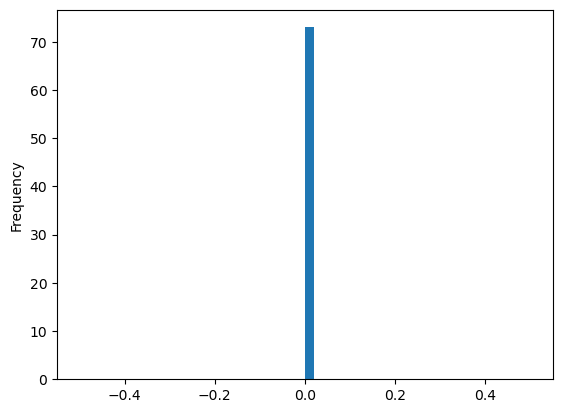

In [15]:
sentiment_bing['compoundscore'].mean()
sentiment_bing['compoundscore'].plot.hist(bins=50)
plt.show()

#### TextBlob

In [16]:
from textblob import TextBlob
sentiment_tb = []
for sentence in apple_df['Cleaned_Review_Text']:
    sentiment_tb.append([sentence, 
                      TextBlob(sentence).sentiment.polarity, 
                      TextBlob(sentence).sentiment.subjectivity])
len(sentiment_tb)

73

In [17]:
# convert it to a dataframe
# three columns: 'review','sentiment','subjectivity'
sentiment_TextBlob = pd.DataFrame(sentiment_tb)
sentiment_TextBlob.columns = ['review','sentiment','subjectivity']
sentiment_TextBlob.head(2)

,review,sentiment,subjectivity
0,"`` great company , definitely helped develop person . ''",0.4,0.625
1,`` excellent place great opportunity grow learn . '',0.9,0.875


In [18]:
# Top five most positive reviews
sentiment_TextBlob.sort_values('sentiment', ascending=False).head()

,review,sentiment,subjectivity
63,`` great company ! '',1.0,0.750
30,`` 've 5 years learned lot within time . emphasis connecting customers level training used help us onboard excellent . '',1.0,1.000
22,`` one best places could ever dream '',1.0,0.300
23,`` great company wonderful place . '',0.9,0.875
1,`` excellent place great opportunity grow learn . '',0.9,0.875


In [19]:
sentiment_TextBlob['sentiment'].mean()

0.4404083743501551

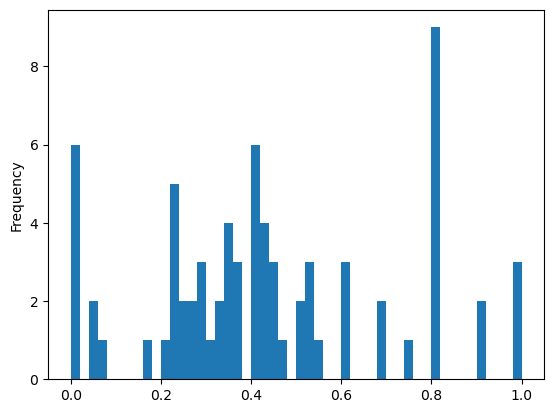

In [20]:
sentiment_TextBlob['sentiment'].plot.hist(bins=50)
plt.show()

### Topic modeling

In [21]:
# tokenize the cleaned review
apple_df['Tokenized_Review_Text'] = apple_df['Cleaned_Review_Text'].apply(word_tokenize)
# Remove specific unwanted characters
#apple_df['Tokenized_Review_Text'] = apple_df['Tokenized_Review_Text'].apply(lambda x:" ".join(x))

apple_df.head(2)

,job_title,employee_review,state,review_url,person_you_work_for,people_you_work_with,work_setting,support,rewards,growth,culture,Cleaned_Review_Text,Tokenized_Review_Text
1,Technical Specialist,"""It was a great company to work for, they definitely helped develop me as a person.""","Dallas, TX",https://www.careerbliss.com/apple/reviews/technical-specialist/#2027278,5,5,5,5,3,5,5,"`` great company , definitely helped develop person . ''","[``, great, company, ,, definitely, helped, develop, person, ., ``]"
2,Apple Employee,"""Excellent place of work and a great opportunity to grow and learn.""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/anonymous-employee/#2025917,5,4,4,5,3,5,3,`` excellent place great opportunity grow learn . '',"[``, excellent, place, great, opportunity, grow, learn, ., ``]"


In [22]:
print(apple_df.columns)

Index(['job_title', 'employee_review', 'state', 'review_url',
       'person_you_work_for', 'people_you_work_with', 'work_setting',
       'support', 'rewards', 'growth', 'culture', 'Cleaned_Review_Text',
       'Tokenized_Review_Text'],
      dtype='object')


In [23]:
# Create a dictionary and corpus for Gensim LDA

dictionary = Dictionary(apple_df['Tokenized_Review_Text'])
corpus = [dictionary.doc2bow(text) for text in apple_df['Tokenized_Review_Text'] ]


print(len(dictionary), len(corpus))

737 73


Coherence score for 2 topics: -6.229779598798402
Coherence score for 3 topics: -6.04031371478559
Coherence score for 4 topics: -8.579016299996036
Coherence score for 5 topics: -8.610577527674653


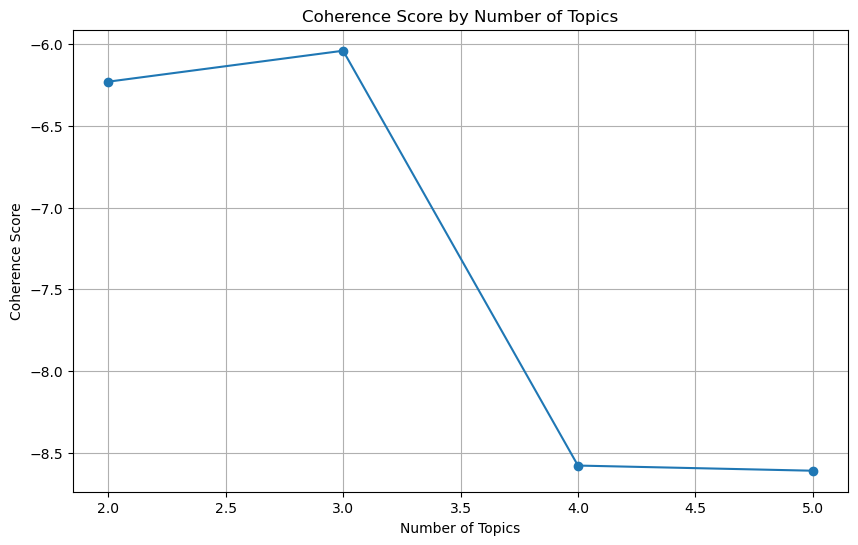

In [24]:
# Set the random seeds
np.random.seed(1)

# Range of topic numbers to evaluate
k_range = list(range(2, 6))
scores = []

# Iterate over different values of k (number of topics)
for k in k_range:
    # Create a new LDA model with k topics
    # Use the class LdaModel directly, not the lda_5 variable
    lda_model = LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=k, 
                        passes=50,
                        random_state=42)
    
    # Compute the coherence score
    cm = CoherenceModel(model=lda_model, 
                       corpus=corpus, 
                       dictionary=dictionary, 
                       coherence='u_mass')
    
    # Get and store the coherence score
    coherence_score = cm.get_coherence()
    print(f"Coherence score for {k} topics: {coherence_score}")
    scores.append(coherence_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics")
plt.grid(True)
plt.show()

In [25]:
# Train LDA model K=3
k=3
lda_model = LdaModel(corpus,num_topics=k, id2word= dictionary,passes=20)

In [26]:
# print term-topic distribution
lda_model.show_topics(num_topics=k )

[(0,
  '0.078*"``" + 0.059*"." + 0.031*"," + 0.031*"great" + 0.019*"company" + 0.009*"customers" + 0.008*"new" + 0.008*"day" + 0.008*"amazing" + 0.007*"excellent"'),
 (1,
  '0.059*"``" + 0.047*"." + 0.015*"company" + 0.012*"," + 0.012*"time" + 0.006*"great" + 0.006*"since" + 0.006*"\'ve" + 0.006*"new" + 0.006*"good"'),
 (2,
  '0.064*"." + 0.055*"," + 0.045*"``" + 0.014*"•" + 0.014*"experience" + 0.010*"years" + 0.010*"good" + 0.010*"place" + 0.009*"company" + 0.008*"data"')]

> Summary of topics:

Topic 0: indicate satisfaction, possibly related to customer experiences.

Topic 1: It reflect perceptions about the organization and experiences over time.

Topic 2: relate to specific job functions.  

#### Document Topic distribution


In [27]:
# Step 1: Get the topic distributions for each document from the LDA model
corpus_lda = [lda_model[doc] for doc in corpus]

# Step 2: Create a Document-Topic Distribution DataFrame
# Initialize an empty list to store topic distributions
doc_topic_dist = []

# Loop through each document's topic distribution and extract probabilities for all topics
for doc in corpus_lda:
    # Create a dictionary with topic indices and probabilities, filling missing topics with 0
    topic_dist = dict(doc)
    topic_probs = [topic_dist.get(i, 0) for i in range(lda_model.num_topics)]
    doc_topic_dist.append(topic_probs)

# Convert the list into a DataFrame
doc_topic_df = pd.DataFrame(doc_topic_dist, columns=[f'Topic_{i}' for i in range(lda_model.num_topics)])

# Step 3: Merge the Document-Topic Distribution DataFrame with the original DataFrame
apple_df_merged = pd.concat([apple_df, doc_topic_df], axis=1)

# Display the merged DataFrame with topic distributions
apple_df_merged.head()

,job_title,employee_review,state,review_url,person_you_work_for,people_you_work_with,work_setting,support,rewards,growth,culture,Cleaned_Review_Text,Tokenized_Review_Text,Topic_0,Topic_1,Topic_2
1,Technical Specialist,"""It was a great company to work for, they definitely helped develop me as a person.""","Dallas, TX",https://www.careerbliss.com/apple/reviews/technical-specialist/#2027278,5.0,5.0,5.0,5.0,3.0,5.0,5.0,"`` great company , definitely helped develop person . ''","[``, great, company, ,, definitely, helped, develop, person, ., ``]",0.447103,0.038111,0.514786
2,Apple Employee,"""Excellent place of work and a great opportunity to grow and learn.""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/anonymous-employee/#2025917,5.0,4.0,4.0,5.0,3.0,5.0,3.0,`` excellent place great opportunity grow learn . '',"[``, excellent, place, great, opportunity, grow, learn, ., ``]",0.981957,0.000000,0.000000
4,Product Service Engineering Technician,"""I was welcomed by the entire team since the beginning. The first couple of months were meant for me to adapt to the team, the processes, the goals, and the mentality. Later on I started receiving my own projects with open freedom to develop them while receiving guidance by my supervisor along the way. I would definitely recommend a job with Apple.""","Cupertino, CA",https://www.careerbliss.com/apple/reviews/product-service-engineering-technician/#2023701,5.0,4.0,5.0,5.0,4.0,4.0,5.0,"`` welcomed entire team since beginning . first couple months meant adapt team , processes , goals , mentality . later started receiving projects open freedom develop receiving guidance supervisor along way . would definitely recommend job . ''","[``, welcomed, entire, team, since, beginning, ., first, couple, months, meant, adapt, team, ,, processes, ,, goals, ,, mentality, ., later, started, receiving, projects, open, freedom, develop, receiving, guidance, supervisor, along, way, ., would, definitely, recommend, job, ., ``]",0.025227,0.952839,0.021935
5,Senior Front End Developer,"""It is a great company to work for""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/senior-front-end-developer/#2021824,4.0,5.0,4.0,5.0,4.0,4.0,5.0,`` great company '',"[``, great, company, ``]",0.558961,0.041102,0.399937
6,Technical Product Manager,"""I have worked in Apple and I have enjoyed what I have learnt in this organization. It has taught me to make products which appeal to the consumer and simplify the process. Excellent opportunity""","Sunnyvale, CA",https://www.careerbliss.com/apple/reviews/technical-product-manager/#2007097,5.0,5.0,5.0,5.0,4.0,5.0,5.0,`` enjoyed learnt organization . taught make products appeal consumer simplify process . excellent opportunity '',"[``, enjoyed, learnt, organization, ., taught, make, products, appeal, consumer, simplify, process, ., excellent, opportunity, ``]",0.000000,0.983571,0.000000


### 3. Part III: Network analytics - Data preparation in the notebook & network visualization w/ Gephi.

In [28]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

def clean_text(Tokenized_Review_Text):
    # Join list into a single string if needed
    if isinstance(Tokenized_Review_Text, list):
        Tokenized_Review_Text = " ".join(Tokenized_Review_Text)
    
    # Convert to lowercase and remove non-alphabet characters
    text = re.sub("[^a-zA-Z]", " ", Tokenized_Review_Text).lower()
    
    # Tokenize and perform POS tagging
    words = word_tokenize(text)
    pos_tags = pos_tag(words)

    # Load the default NLTK stopwords set for English
    stop_words = set(stopwords.words('english'))
    
    # Select nouns
    nouns = [word for word, tag in pos_tags if tag in ["NN", "NNS"]]

    # Filter out stopwords and words shorter than 3 characters
    filtered_nouns = [noun for noun in nouns if noun not in stop_words and len(noun) >= 3]

    # Lemmatize the filtered nouns to singular form
    singular_nouns = [lemmatizer.lemmatize(noun, pos='n') for noun in filtered_nouns]

    return singular_nouns


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\niral\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [29]:
# Creating a DataFrame to store network data
bigrams = []

# Extract mentions from each tweet
for row in apple_df_merged['Tokenized_Review_Text'][:2]:
    network_analytics = clean_text(row)
    for pair in combinations(network_analytics,2):
        bigrams.append(pair)

bigrams_df = pd.DataFrame(bigrams,columns=['Source','Target'])
bigrams_df.head()

,Source,Target
0,company,person
1,place,opportunity
2,place,grow
3,place,learn
4,opportunity,grow


In [30]:
bigrams_df.to_csv("bigrams_df.csv",index=False)

In [31]:
import networkx as nx

# Build your graph
G=nx.from_pandas_edgelist(bigrams_df, 'Source', 'Target', create_using=nx.DiGraph()) 
G

In [32]:
pos = nx.spring_layout(G, seed=42)

In [33]:
# define metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)


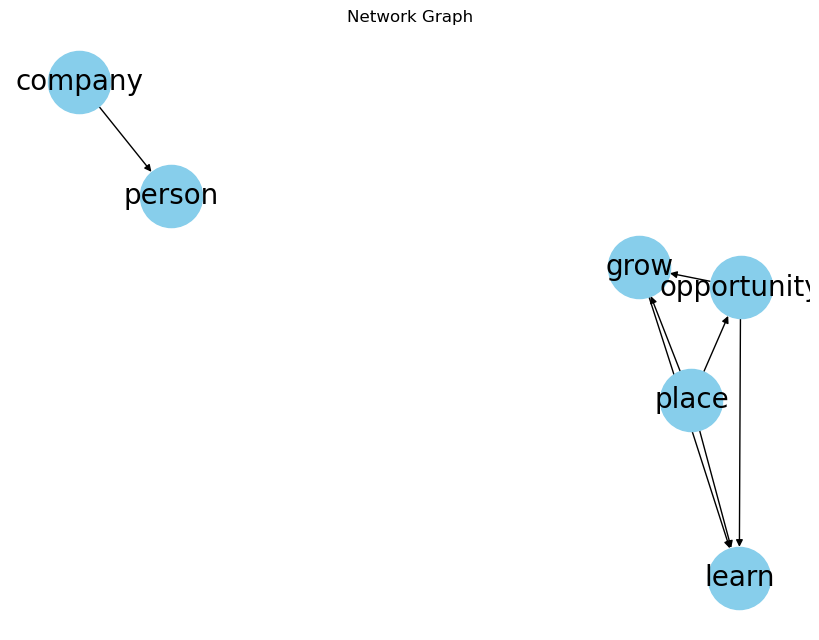

In [34]:
# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, font_size=20, font_color='black')
plt.title("Network Graph")
plt.show()

In [35]:
# Create a DataFrame with all metrics
metrics_df = pd.DataFrame({
    'Node': list(G.nodes),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes]
})

metrics_df.sort_values(by='Degree Centrality', ascending=False, inplace=True)
metrics_df

,Node,Degree Centrality,Betweenness Centrality,Closeness Centrality
2,place,0.6,0.0,0.0
3,opportunity,0.6,0.0,0.2
4,grow,0.6,0.0,0.4
5,learn,0.6,0.0,0.6
0,company,0.2,0.0,0.0
1,person,0.2,0.0,0.2


In [36]:
# Perform community detection using the greedy modularity algorithm
from networkx.algorithms.community import greedy_modularity_communities

# Find clusters
clusters = list(greedy_modularity_communities(G))

# Assign cluster labels
cluster_mapping = {}
for cluster_id, cluster_nodes in enumerate(clusters):
    for node in cluster_nodes:
        cluster_mapping[node] = cluster_id

# Add cluster data as a node attribute
nx.set_node_attributes(G, cluster_mapping, 'cluster')

# Print clustering results
print("Clusters found:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {list(cluster)}")

Clusters found:
Cluster 1: ['opportunity', 'learn', 'grow', 'place']
Cluster 2: ['company', 'person']


### 4. Final analysis & storytelling

#### Average rating falls between 4.02 to 4.63. Employees are most satisfied with people they work with but employees not satisfied with their personal growth. From Descriptive Analytics the most frequent word has been used in reviews is 'Great company'.

#### Sentiment Analysis 
#### Based on Bing-Liu 73 number of samples were taken and all sentiment scores are zero. suggests that all reviews are neutral. 
#### TextBlob sentiment analysis also suggest that all reviews are positive and there is no strong negative reviews.
 
#### Topic Modeling

> Topic 0: indicate satisfaction, possibly related to customer experiences.

> Topic 1: It reflect perceptions about the organization and experiences over time.

> Topic 2: relate to specific job functions.

#### Company can focus on employess personal growth and apreciation towards thier work will help in employee satisfaction. 